In [2]:
ls

Data/  Project.ipynb  README.md


In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf


train_file_path = "Data/train.csv"
test_file_path = "Data/test.json"
submission_file_path = 'Data/submission.csv'
train_data = pd.read_csv(train_file_path)
print("Train Data Sample:")
print(train_data.head())

print("\nTrain Data Columns:")
print(train_data.columns)



test_data = pd.read_json(test_file_path).T
test_data.head()

submission_data = pd.read_csv(submission_file_path)


print("\nTest Data Sample:")
print(test_data.head())
print(test_data.columns)

# submission.csv 파일 읽기
submission_data = pd.read_csv(submission_file_path)
print("\nSubmission Data Sample:")
print(submission_data.head())
print(submission_data.columns)

Train Data Sample:
   idx        class                                       conversation
0    0        협박 대화  지금 당장 뉴스 기사 내가 불러준 대로 보도 해\n 팩트 체크가 되지 않은 기사는 ...
1    1    기타 괴롭힘 대화  이 버러지 같은게 너 내가 누군줄알아?\n손님 욕하시면 안됩니다. \n어디서 말대꾸...
2    2    기타 괴롭힘 대화  공책 돌려받길 원하면 빨리 뛰어봐. 이 굼벵아.\n빨리 내놔.\n빨릐 내놔아. 빨리...
3    3  직장 내 괴롭힘 대화  사장님 저기 말할게 있는데요\n뭔데 임마\n아니 우리 게임회사는 전체이용가 게임이잖...
4    4        협박 대화  죽고 싶어서 환장했어? 왜 이렇게 말을 안 들어?\n 죄송해요. 한 번만 봐주세요....

Train Data Columns:
Index(['idx', 'class', 'conversation'], dtype='object')

Test Data Sample:
                                                    text
t_000  아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001  우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? ...
t_002  너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003  이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004  아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
Index(['text'], dtype='object')

Submission Data Sample:
  file_name  class
0     t_000    NaN
1     t_001    NaN
2  

In [4]:
# train 데이터 구조 및 통계 정보 확인
print("\nTrain Data Info:")
print(train_data.info())

# test 데이터 구조 및 통계 정보 확인
print("\nTest Data Info:")
print(test_data.info())

# submission 데이터 구조 및 통계 정보 확인
print("\nSubmission Data Info:")
print(submission_data.info())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4906 entries, 0 to 4905
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4906 non-null   int64 
 1   class         4906 non-null   object
 2   conversation  4906 non-null   object
dtypes: int64(1), object(2)
memory usage: 115.1+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, t_000 to t_499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
dtypes: object(1)
memory usage: 24.0+ KB
None

Submission Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  400 non-null    object 
 1   class      0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 6.

In [5]:
# 결측치 확인
print("\nTrain Data Missing Values:")
print(train_data.isnull().sum())

print("\nTest Data Missing Values:")
print(test_data.isnull().sum())

print("\nSubmission Data Missing Values:")
print(submission_data.isnull().sum())



Train Data Missing Values:
idx             0
class           0
conversation    0
dtype: int64

Test Data Missing Values:
text    0
dtype: int64

Submission Data Missing Values:
file_name      0
class        400
dtype: int64


In [6]:
# 결측치 확인
print("\nTrain Data Missing Values:")
print(train_data.isnull().sum())

print("\nTest Data Missing Values:")
print(test_data.isnull().sum())

print("\nSubmission Data Missing Values:")
print(submission_data.isnull().sum())



Train Data Missing Values:
idx             0
class           0
conversation    0
dtype: int64

Test Data Missing Values:
text    0
dtype: int64

Submission Data Missing Values:
file_name      0
class        400
dtype: int64


In [7]:
label_col = 'class' if 'class' in train_data.columns else train_data.columns[-1]  # Assuming label column is the last one if unnamed
print("\nTrain Data Label Distribution:")
print(train_data[label_col].value_counts())


Train Data Label Distribution:
기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
일반 대화           956
협박 대화           896
Name: class, dtype: int64


In [8]:
# 텍스트 길이 분석
text_col = 'conversation' if 'conversation' in train_data.columns else train_data.columns[0]  # Assuming text column is the first one if unnamed

# 텍스트 데이터 타입 확인 및 정리
train_data['text_length'] = train_data[text_col].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
test_data['text_length'] = test_data['text'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)

print("\nTrain Data Text Length Stats:")
print(train_data['text_length'].describe())

print("\nTest Data Text Length Stats:")
print(test_data['text_length'].describe())


Train Data Text Length Stats:
count    4906.000000
mean      258.097228
std       143.286725
min        41.000000
25%       162.000000
50%       218.000000
75%       306.000000
max       885.000000
Name: text_length, dtype: float64

Test Data Text Length Stats:
count    500.000000
mean     213.626000
std      101.240473
min       68.000000
25%      143.000000
50%      189.000000
75%      253.500000
max      722.000000
Name: text_length, dtype: float64


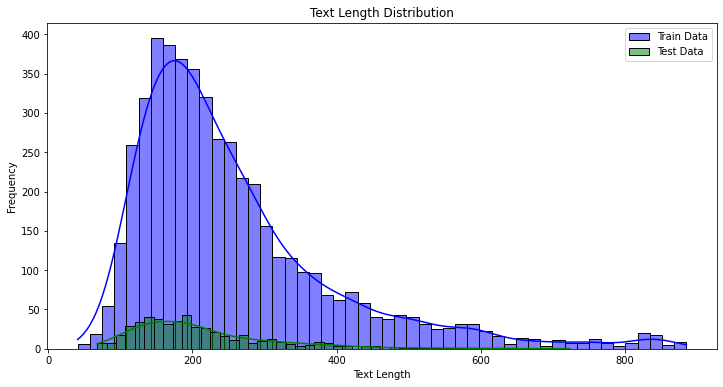

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 텍스트 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(train_data['text_length'], bins=50, kde=True, color='blue', label='Train Data')
sns.histplot(test_data['text_length'], bins=50, kde=True, color='green', label='Test Data')
plt.legend()
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()